In [ ]:
# !pip uninstall -y numpy scipy tensorflow tensorflow-gpu
# !pip install numpy==1.23.5
# !pip install scipy==1.10.1
# !pip install tensorflow==2.12.0
# !pip install gensim==4.3.1
# !pip install conllu

# Part-of-Speech Tagging with MLP

This notebook implements a Part-of-Speech (POS) tagger using a Multi-Layer Perceptron (MLP)
for one of the languages from the Universal Dependencies treebanks.

## 1. Introduction

Part-of-speech tagging is the process of assigning a part-of-speech tag (such as noun, verb, adjective, etc.)
to each word in a text. In this implementation, we use an MLP operating on windows of words.
We use data from the Universal Dependencies treebanks and pre-trained word embeddings as features.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import os
import urllib.request
import zipfile
import conllu
import gensim.downloader as api
from tqdm import tqdm

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input

# Scikit-learn imports
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score, accuracy_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## 2. Dataset

We'll use the Universal Dependencies treebanks for our POS tagging task.
These treebanks provide annotated text data for multiple languages with part-of-speech tags.


In [ ]:
# Constants
LANGUAGE = "English"
TREEBANK = "UD_English-EWT"
TREEBANK_URL = "https://github.com/UniversalDependencies/UD_English-EWT/archive/master.zip"
WINDOW_SIZE = 2  # Context window size (words before and after the target word)
EMBEDDING_DIM = 100  # Dimension of word embeddings
BATCH_SIZE = 64
EPOCHS = 20
HIDDEN_LAYERS = [128, 64]  # Hidden layer sizes
DROPOUT_RATE = 0.3

# Function to download and extract the treebank
def download_treebank(url, treebank_name):
    zip_path = f"{treebank_name}.zip"
    if not os.path.exists(zip_path):
        print(f"Downloading {treebank_name}...")
        urllib.request.urlretrieve(url, zip_path)

    extract_dir = f"{treebank_name}-data"
    if not os.path.exists(extract_dir):
        print(f"Extracting {treebank_name}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    return extract_dir

# Function to load and parse the CoNLL-U files
def load_conllu_data(treebank_dir, treebank_name):
    # Find the CoNLL-U files for train, dev, and test
    base_dir = os.path.join(treebank_dir, f"{treebank_name}-master")
    train_file = None
    dev_file = None
    test_file = None

    for file in os.listdir(base_dir):
        if file.endswith(".conllu"):
            if "train" in file:
                train_file = os.path.join(base_dir, file)
            elif "dev" in file:
                dev_file = os.path.join(base_dir, file)
            elif "test" in file:
                test_file = os.path.join(base_dir, file)

    # Load and parse the CoNLL-U files
    train_data = []
    dev_data = []
    test_data = []

    if train_file:
        with open(train_file, "r", encoding="utf-8") as f:
            train_data = conllu.parse(f.read())

    if dev_file:
        with open(dev_file, "r", encoding="utf-8") as f:
            dev_data = conllu.parse(f.read())

    if test_file:
        with open(test_file, "r", encoding="utf-8") as f:
            test_data = conllu.parse(f.read())

    return train_data, dev_data, test_data

# Function to extract sentences and POS tags from the parsed data
def extract_sentences_and_tags(data):
    sentences = []
    pos_tags = []

    for sentence in data:
        words = []
        tags = []

        for token in sentence:
            # Skip tokens that are not words (e.g., punctuation)
            if token["upos"] != "_":
                words.append(token["form"].lower())
                tags.append(token["upos"])

        if words:  # Only add non-empty sentences
            sentences.append(words)
            pos_tags.append(tags)

    return sentences, pos_tags


### 2.1 Dataset Statistics


In [ ]:
# Calculate dataset statistics
def calculate_dataset_stats(sentences, tags):
    num_sentences = len(sentences)
    num_words = sum(len(s) for s in sentences)
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0

    # Calculate vocabulary size
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab_size = len(vocab)

    # Calculate tag distribution
    tag_counter = Counter()
    for tag_seq in tags:
        tag_counter.update(tag_seq)

    return {
        "num_sentences": num_sentences,
        "num_words": num_words,
        "avg_sentence_length": avg_sentence_length,
        "vocab_size": vocab_size,
        "tag_distribution": tag_counter
    }

# Download and load the data
print("Downloading and loading the data...")
treebank_dir = download_treebank(TREEBANK_URL, TREEBANK)
train_data, dev_data, test_data = load_conllu_data(treebank_dir, TREEBANK)

# Extract sentences and tags
print("Extracting sentences and tags...")
train_sentences, train_pos_tags = extract_sentences_and_tags(train_data)
dev_sentences, dev_pos_tags = extract_sentences_and_tags(dev_data)
test_sentences, test_pos_tags = extract_sentences_and_tags(test_data)

# Calculate and display dataset statistics
print("Calculating dataset statistics...")
train_stats = calculate_dataset_stats(train_sentences, train_pos_tags)
dev_stats = calculate_dataset_stats(dev_sentences, dev_pos_tags)
test_stats = calculate_dataset_stats(test_sentences, test_pos_tags)

print(f"Dataset Statistics for {LANGUAGE} ({TREEBANK}):\n")
print("Training Set:")
print(f"  Number of sentences: {train_stats['num_sentences']}")
print(f"  Number of words: {train_stats['num_words']}")
print(f"  Average sentence length: {train_stats['avg_sentence_length']:.2f}")
print(f"  Vocabulary size: {train_stats['vocab_size']}")
print("\nDevelopment Set:")
print(f"  Number of sentences: {dev_stats['num_sentences']}")
print(f"  Number of words: {dev_stats['num_words']}")
print(f"  Average sentence length: {dev_stats['avg_sentence_length']:.2f}")
print("\nTest Set:")
print(f"  Number of sentences: {test_stats['num_sentences']}")
print(f"  Number of words: {test_stats['num_words']}")
print(f"  Average sentence length: {test_stats['avg_sentence_length']:.2f}")

# Display tag distribution
print("\nPOS Tag Distribution (Training Set):")
for tag, count in sorted(train_stats['tag_distribution'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {tag}: {count} ({count/train_stats['num_words']*100:.2f}%)")


Extracting UD_English-EWT...
Extracting sentences and tags...
Calculating dataset statistics...
Dataset Statistics for English (UD_English-EWT):

Training Set:
  Number of sentences: 12544
  Number of words: 204614
  Average sentence length: 16.31
  Vocabulary size: 16654

Development Set:
  Number of sentences: 2001
  Number of words: 25151
  Average sentence length: 12.57

Test Set:
  Number of sentences: 2077
  Number of words: 25096
  Average sentence length: 12.08

POS Tag Distribution (Training Set):
  NOUN: 34751 (16.98%)
  PUNCT: 23596 (11.53%)
  VERB: 22603 (11.05%)
  PRON: 18677 (9.13%)
  ADP: 17748 (8.67%)
  DET: 16299 (7.97%)
  ADJ: 13138 (6.42%)
  AUX: 12818 (6.26%)
  PROPN: 12620 (6.17%)
  ADV: 10167 (4.97%)
  CCONJ: 6687 (3.27%)
  PART: 5748 (2.81%)
  NUM: 4126 (2.02%)
  SCONJ: 3819 (1.87%)
  SYM: 722 (0.35%)
  INTJ: 695 (0.34%)
  X: 400 (0.20%)


## 3. Feature Extraction

We'll use pre-trained word embeddings as features for our POS tagger.
We'll create a window of words around each target word to provide context for the MLP.


In [ ]:
# Create vocabulary and tag mappings
def create_mappings(train_sentences, train_tags):
    # Create word-to-index mapping
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}  # Special tokens
    for sentence in train_sentences:
        for word in sentence:
            if word not in word_to_idx:
                word_to_idx[word] = len(word_to_idx)

    # Create tag-to-index mapping
    tag_to_idx = {}
    for tag_seq in train_tags:
        for tag in tag_seq:
            if tag not in tag_to_idx:
                tag_to_idx[tag] = len(tag_to_idx)

    # Create index-to-tag mapping for later use
    idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

    return word_to_idx, tag_to_idx, idx_to_tag

# Load pre-trained word embeddings
print("\nLoading pre-trained word embeddings...")
word_vectors = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe embeddings
EMBEDDING_DIM = word_vectors.vector_size
print(f"Loaded {len(word_vectors.key_to_index)} word vectors with dimension {EMBEDDING_DIM}")

# Create mappings
print("Creating word and tag mappings...")
word_to_idx, tag_to_idx, idx_to_tag = create_mappings(train_sentences, train_pos_tags)
print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Number of POS tags: {len(tag_to_idx)}")
print(f"POS tags: {list(tag_to_idx.keys())}")

# Create embedding matrix
def create_embedding_matrix(word_to_idx, word_vectors, embedding_dim):
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, idx in word_to_idx.items():
        if word in word_vectors:
            embedding_matrix[idx] = word_vectors[word]
        elif word == "<PAD>":
            embedding_matrix[idx] = np.zeros(embedding_dim)  # Zero vector for padding
        else:  # <UNK> or words not in pre-trained embeddings
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return embedding_matrix

print("Creating embedding matrix...")
embedding_matrix = create_embedding_matrix(word_to_idx, word_vectors, EMBEDDING_DIM)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

# Prepare data for MLP (using the approach from Part_3_Exercise_10.ipynb)
def prepare_data_for_mlp(sentences, pos_tags, word_to_idx, tag_to_idx, window_size):
    X_word = []  # Target word
    X_context = []  # Context words
    y = []  # Tags

    for sentence, tags in zip(sentences, pos_tags):
        for i, (word, tag) in enumerate(zip(sentence, tags)):
            # Get the target word index
            word_idx = word_to_idx.get(word, word_to_idx["<UNK>"])

            # Get context words
            context = []
            for j in range(i - window_size, i + window_size + 1):
                if j < 0 or j >= len(sentence) or j == i:  # Skip target word
                    continue
                context_idx = word_to_idx.get(sentence[j], word_to_idx["<UNK>"])
                context.append(context_idx)

            # Pad context if needed
            while len(context) < 2 * window_size:
                context.append(word_to_idx["<PAD>"])

            # Add to dataset
            X_word.append(word_idx)
            X_context.append(context)
            y.append(tag_to_idx[tag])

    return np.array(X_word), np.array(X_context), np.array(y)

# Prepare data for all sets
print("Preparing data for MLP model...")
X_train_word, X_train_context, y_train = prepare_data_for_mlp(train_sentences, train_pos_tags, word_to_idx, tag_to_idx, WINDOW_SIZE)
X_dev_word, X_dev_context, y_dev = prepare_data_for_mlp(dev_sentences, dev_pos_tags, word_to_idx, tag_to_idx, WINDOW_SIZE)
X_test_word, X_test_context, y_test = prepare_data_for_mlp(test_sentences, test_pos_tags, word_to_idx, tag_to_idx, WINDOW_SIZE)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=len(tag_to_idx))
y_dev_one_hot = to_categorical(y_dev, num_classes=len(tag_to_idx))
y_test_one_hot = to_categorical(y_test, num_classes=len(tag_to_idx))

print(f"Training samples: {len(X_train_word)}")
print(f"Development samples: {len(X_dev_word)}")
print(f"Test samples: {len(X_test_word)}")



Loading pre-trained word embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded 400000 word vectors with dimension 100
Creating word and tag mappings...
Vocabulary size: 16656
Number of POS tags: 17
POS tags: ['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX', 'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', 'INTJ', 'X', 'SYM']
Creating embedding matrix...
Embedding matrix shape: (16656, 100)
Preparing data for MLP model...
Training samples: 204614
Development samples: 25151
Test samples: 25096


## 4. Baseline Model

We'll implement a baseline model that tags each word with the most frequent tag it had in the training data.
For words not seen in the training data, the baseline will use the most frequent tag overall.


In [ ]:
class BaselineTagger:
    def __init__(self):
        self.word_to_tag = {}
        self.most_common_tag = None

    def train(self, sentences, tags):
        # Count word-tag occurrences
        word_tag_counts = defaultdict(Counter)
        tag_counts = Counter()

        for sentence, tag_seq in zip(sentences, tags):
            for word, tag in zip(sentence, tag_seq):
                word_tag_counts[word][tag] += 1
                tag_counts[tag] += 1

        # Find the most frequent tag for each word
        for word, tag_counter in word_tag_counts.items():
            self.word_to_tag[word] = tag_counter.most_common(1)[0][0]

        # Find the most common tag overall
        self.most_common_tag = tag_counts.most_common(1)[0][0]

    def predict(self, sentences):
        predictions = []

        for sentence in sentences:
            sentence_preds = []
            for word in sentence:
                # Use the most frequent tag for this word, or the most common tag if the word is unseen
                tag = self.word_to_tag.get(word, self.most_common_tag)
                sentence_preds.append(tag)
            predictions.append(sentence_preds)

        return predictions

# Function to evaluate predictions
def evaluate_predictions(true_tags, pred_tags, tag_to_idx):
    # Flatten the lists of tags
    true_flat = [tag for sent in true_tags for tag in sent]
    pred_flat = [tag for sent in pred_tags for tag in sent]

    # Convert tags to indices
    true_indices = [tag_to_idx[tag] for tag in true_flat]
    pred_indices = [tag_to_idx[tag] for tag in pred_flat]

    # Calculate metrics for each class
    precision = precision_score(true_indices, pred_indices, average=None, zero_division=0)
    recall = recall_score(true_indices, pred_indices, average=None, zero_division=0)
    f1 = f1_score(true_indices, pred_indices, average=None, zero_division=0)

    # Calculate macro-averaged metrics
    macro_precision = precision_score(true_indices, pred_indices, average='macro', zero_division=0)
    macro_recall = recall_score(true_indices, pred_indices, average='macro', zero_division=0)
    macro_f1 = f1_score(true_indices, pred_indices, average='macro', zero_division=0)

    # Calculate PR AUC for each class
    pr_auc = []
    for i in range(len(tag_to_idx)):
        # Convert to binary classification problem
        true_binary = [1 if t == i else 0 for t in true_indices]
        pred_binary = [1 if p == i else 0 for p in pred_indices]

        # Calculate precision-recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(true_binary, pred_binary)
        pr_auc.append(auc(recall_curve, precision_curve))

    # Calculate macro-averaged PR AUC
    macro_pr_auc = np.mean(pr_auc)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "pr_auc": pr_auc,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "macro_pr_auc": macro_pr_auc
    }

# Train and evaluate the baseline model
print("\nTraining and evaluating the baseline model...")
baseline = BaselineTagger()
baseline.train(train_sentences, train_pos_tags)

train_baseline_preds = baseline.predict(train_sentences)
dev_baseline_preds = baseline.predict(dev_sentences)
test_baseline_preds = baseline.predict(test_sentences)

train_baseline_metrics = evaluate_predictions(train_pos_tags, train_baseline_preds, tag_to_idx)
dev_baseline_metrics = evaluate_predictions(dev_pos_tags, dev_baseline_preds, tag_to_idx)
test_baseline_metrics = evaluate_predictions(test_pos_tags, test_baseline_preds, tag_to_idx)

print("Baseline Model Results:\n")
print("Training Set:")
print(f"  Macro-averaged Precision: {train_baseline_metrics['macro_precision']:.4f}")
print(f"  Macro-averaged Recall: {train_baseline_metrics['macro_recall']:.4f}")
print(f"  Macro-averaged F1: {train_baseline_metrics['macro_f1']:.4f}")
print(f"  Macro-averaged PR AUC: {train_baseline_metrics['macro_pr_auc']:.4f}")

print("\nDevelopment Set:")
print(f"  Macro-averaged Precision: {dev_baseline_metrics['macro_precision']:.4f}")
print(f"  Macro-averaged Recall: {dev_baseline_metrics['macro_recall']:.4f}")
print(f"  Macro-averaged F1: {dev_baseline_metrics['macro_f1']:.4f}")
print(f"  Macro-averaged PR AUC: {dev_baseline_metrics['macro_pr_auc']:.4f}")

print("\nTest Set:")
print(f"  Macro-averaged Precision: {test_baseline_metrics['macro_precision']:.4f}")
print(f"  Macro-averaged Recall: {test_baseline_metrics['macro_recall']:.4f}")
print(f"  Macro-averaged F1: {test_baseline_metrics['macro_f1']:.4f}")
print(f"  Macro-averaged PR AUC: {test_baseline_metrics['macro_pr_auc']:.4f}")



Training and evaluating the baseline model...
Baseline Model Results:

Training Set:
  Macro-averaged Precision: 0.8964
  Macro-averaged Recall: 0.8723
  Macro-averaged F1: 0.8799
  Macro-averaged PR AUC: 0.8868

Development Set:
  Macro-averaged Precision: 0.8361
  Macro-averaged Recall: 0.7741
  Macro-averaged F1: 0.7913
  Macro-averaged PR AUC: 0.8092

Test Set:
  Macro-averaged Precision: 0.8195
  Macro-averaged Recall: 0.7752
  Macro-averaged F1: 0.7863
  Macro-averaged PR AUC: 0.8014


## 5. MLP Model Implementation

Now we'll implement a Multi-Layer Perceptron (MLP) for POS tagging using the TensorFlow/Keras framework.
We'll use a dual-input approach that processes the target word and its context separately.


In [ ]:
# Build the MLP model
def build_mlp_model(vocab_size, embedding_dim, embedding_matrix, window_size, n_tags, hidden_layers, dropout_rate):
    # Input layers
    word_input = Input(shape=(1,), dtype='int32', name='word_input')
    context_input = Input(shape=(2 * window_size,), dtype='int32', name='context_input')

    # Embedding layer (shared between word and context)
    embedding_layer = Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        trainable=True,
        name='embedding_layer'
    )

    # Apply embedding to inputs
    word_embedding = embedding_layer(word_input)
    context_embedding = embedding_layer(context_input)

    # Flatten embeddings
    word_flat = Flatten()(word_embedding)
    context_flat = Flatten()(context_embedding)

    # Concatenate word and context features
    concat = tf.keras.layers.concatenate([word_flat, context_flat])

    # Hidden layers
    x = concat
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    # Output layer
    output = Dense(n_tags, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=[word_input, context_input], outputs=output)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the MLP model
print("\nBuilding the MLP model...")
mlp_model = build_mlp_model(
    vocab_size=len(word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    embedding_matrix=embedding_matrix,
    window_size=WINDOW_SIZE,
    n_tags=len(tag_to_idx),
    hidden_layers=HIDDEN_LAYERS,
    dropout_rate=DROPOUT_RATE
)

# Print model summary
mlp_model.summary()

# Reshape input data for the model
X_train_word = X_train_word.reshape(-1, 1)
X_dev_word = X_dev_word.reshape(-1, 1)
X_test_word = X_test_word.reshape(-1, 1)

# Set up callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_pos_tagger_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



Building the MLP model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 context_input (InputLayer)     [(None, 4)]          0           []                               
                                                                                                  
 embedding_layer (Embedding)    multiple             1665600     ['word_input[0][0]',             
                                                                  'context_input[0][0]']          
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['

## 6. Training and Evaluation

We'll train the MLP model on the training data and evaluate it on the development and test sets.
We'll use early stopping to prevent overfitting and save the best model based on validation loss.


In [ ]:
# Train the model
print("\nTraining the MLP model...")
history = mlp_model.fit(
    [X_train_word, X_train_context],
    y_train_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_dev_word, X_dev_context], y_dev_one_hot),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Load the best model
mlp_model = tf.keras.models.load_model('best_pos_tagger_model.h5')

# Make predictions
print("\nMaking predictions with the MLP model...")
train_mlp_probs = mlp_model.predict([X_train_word, X_train_context])
dev_mlp_probs = mlp_model.predict([X_dev_word, X_dev_context])
test_mlp_probs = mlp_model.predict([X_test_word, X_test_context])

train_mlp_preds = np.argmax(train_mlp_probs, axis=1)
dev_mlp_preds = np.argmax(dev_mlp_probs, axis=1)
test_mlp_preds = np.argmax(test_mlp_probs, axis=1)

# Convert predictions back to sentence format
def convert_predictions_to_tags(predictions, sentences, idx_to_tag):
    """
    Convert model predictions back to POS tags for each sentence.

    Args:
        predictions: Array of predicted tag indices from the model
        sentences: List of sentences (each a list of words)
        idx_to_tag: Mapping from tag indices to tag names

    Returns:
        List of lists, where each inner list contains the predicted tags for a sentence
    """
    # Initialize the result structure
    sentence_predictions = []

    # Keep track of the current position in the predictions array
    pred_idx = 0

    # Process each sentence
    for sentence in sentences:
        # For each sentence, we have exactly len(sentence) predictions
        sent_preds = []
        for _ in range(len(sentence)):
            if pred_idx < len(predictions):
                tag_idx = predictions[pred_idx]
                sent_preds.append(idx_to_tag[tag_idx])
                pred_idx += 1

        # Add the predictions for this sentence to the result
        sentence_predictions.append(sent_preds)

    return sentence_predictions

# Convert predictions to tags
train_mlp_pred_tags = convert_predictions_to_tags(train_mlp_preds, train_sentences, idx_to_tag)
dev_mlp_pred_tags = convert_predictions_to_tags(dev_mlp_preds, dev_sentences, idx_to_tag)
test_mlp_pred_tags = convert_predictions_to_tags(test_mlp_preds, test_sentences, idx_to_tag)

# Evaluate the MLP model
train_mlp_metrics = evaluate_predictions(train_pos_tags, train_mlp_pred_tags, tag_to_idx)
dev_mlp_metrics = evaluate_predictions(dev_pos_tags, dev_mlp_pred_tags, tag_to_idx)
test_mlp_metrics = evaluate_predictions(test_pos_tags, test_mlp_pred_tags, tag_to_idx)

print("MLP Model Results:\n")
print("Training Set:")
print(f"  Macro-averaged Precision: {train_mlp_metrics['macro_precision']:.4f}")
print(f"  Macro-averaged Recall: {train_mlp_metrics['macro_recall']:.4f}")
print(f"  Macro-averaged F1: {train_mlp_metrics['macro_f1']:.4f}")
print(f"  Macro-averaged PR AUC: {train_mlp_metrics['macro_pr_auc']:.4f}")

print("\nDevelopment Set:")
print(f"  Macro-averaged Precision: {dev_mlp_metrics['macro_precision']:.4f}")
print(f"  Macro-averaged Recall: {dev_mlp_metrics['macro_recall']:.4f}")
print(f"  Macro-averaged F1: {dev_mlp_metrics['macro_f1']:.4f}")
print(f"  Macro-averaged PR AUC: {dev_mlp_metrics['macro_pr_auc']:.4f}")

print("\nTest Set:")
print(f"  Macro-averaged Precision: {test_mlp_metrics['macro_precision']:.4f}")
print(f"  Macro-averaged Recall: {test_mlp_metrics['macro_recall']:.4f}")
print(f"  Macro-averaged F1: {test_mlp_metrics['macro_f1']:.4f}")
print(f"  Macro-averaged PR AUC: {test_mlp_metrics['macro_pr_auc']:.4f}")



Training the MLP model...
Epoch 1/20
3193/3198 [============================>.] - ETA: 0s - loss: 0.5156 - accuracy: 0.8444
Epoch 1: val_loss improved from inf to 0.42594, saving model to best_pos_tagger_model.h5
3198/3198 [==============================] - 36s 11ms/step - loss: 0.5152 - accuracy: 0.8445 - val_loss: 0.4259 - val_accuracy: 0.8805
Epoch 2/20
3194/3198 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9367
Epoch 2: val_loss improved from 0.42594 to 0.38608, saving model to best_pos_tagger_model.h5
3198/3198 [==============================] - 30s 9ms/step - loss: 0.2166 - accuracy: 0.9367 - val_loss: 0.3861 - val_accuracy: 0.8890
Epoch 3/20
3197/3198 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9530
Epoch 3: val_loss did not improve from 0.38608
3198/3198 [==============================] - 34s 11ms/step - loss: 0.1574 - accuracy: 0.9530 - val_loss: 0.4230 - val_accuracy: 0.8946
Epoch 4/20
3195/3198 [========================

## 7. Visualization and Reporting

We'll create visualizations to better understand the model's performance.


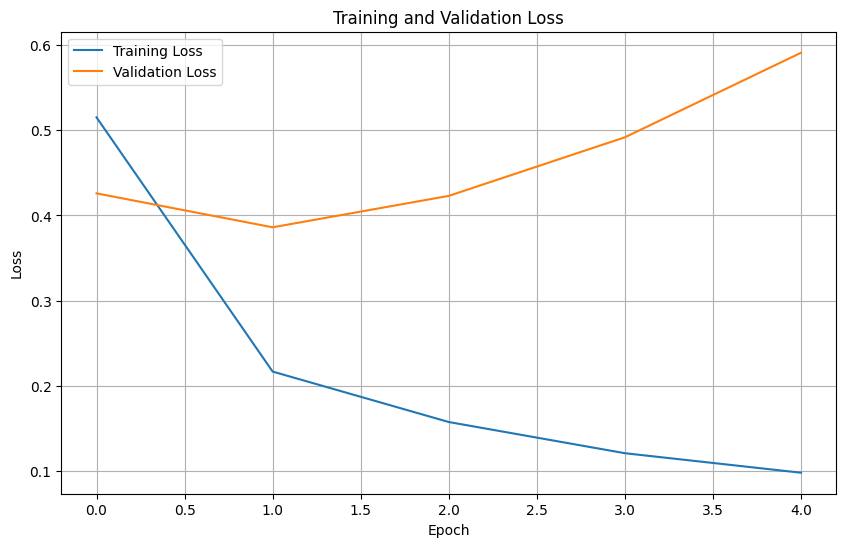

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()


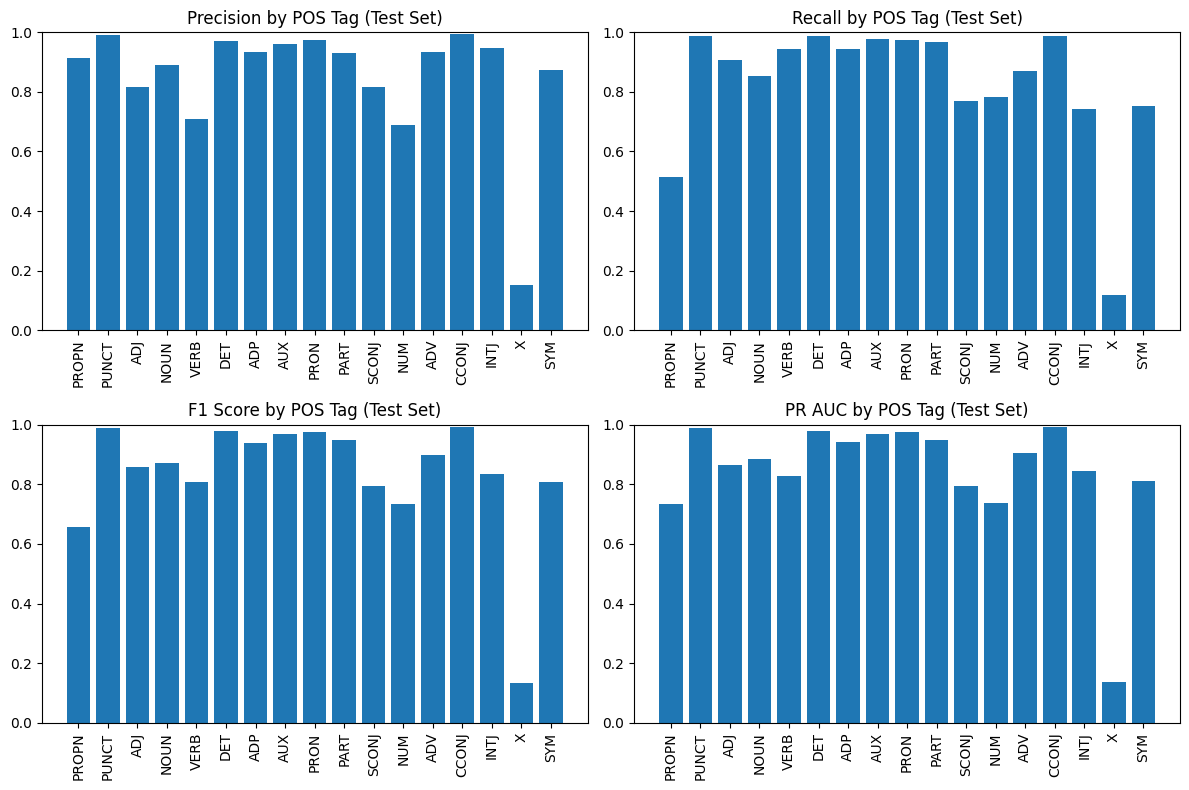

In [ ]:
# Plot per-class metrics for the MLP model
plt.figure(figsize=(12, 8))

# Get the tag names
tags = list(tag_to_idx.keys())

# Plot precision for each class
plt.subplot(2, 2, 1)
plt.bar(tags, test_mlp_metrics['precision'])
plt.title('Precision by POS Tag (Test Set)')
plt.xticks(rotation=90)
plt.ylim(0, 1)

# Plot recall for each class
plt.subplot(2, 2, 2)
plt.bar(tags, test_mlp_metrics['recall'])
plt.title('Recall by POS Tag (Test Set)')
plt.xticks(rotation=90)
plt.ylim(0, 1)

# Plot F1 for each class
plt.subplot(2, 2, 3)
plt.bar(tags, test_mlp_metrics['f1'])
plt.title('F1 Score by POS Tag (Test Set)')
plt.xticks(rotation=90)
plt.ylim(0, 1)

# Plot PR AUC for each class
plt.subplot(2, 2, 4)
plt.bar(tags, test_mlp_metrics['pr_auc'])
plt.title('PR AUC by POS Tag (Test Set)')
plt.xticks(rotation=90)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('per_class_metrics.png')
plt.show()


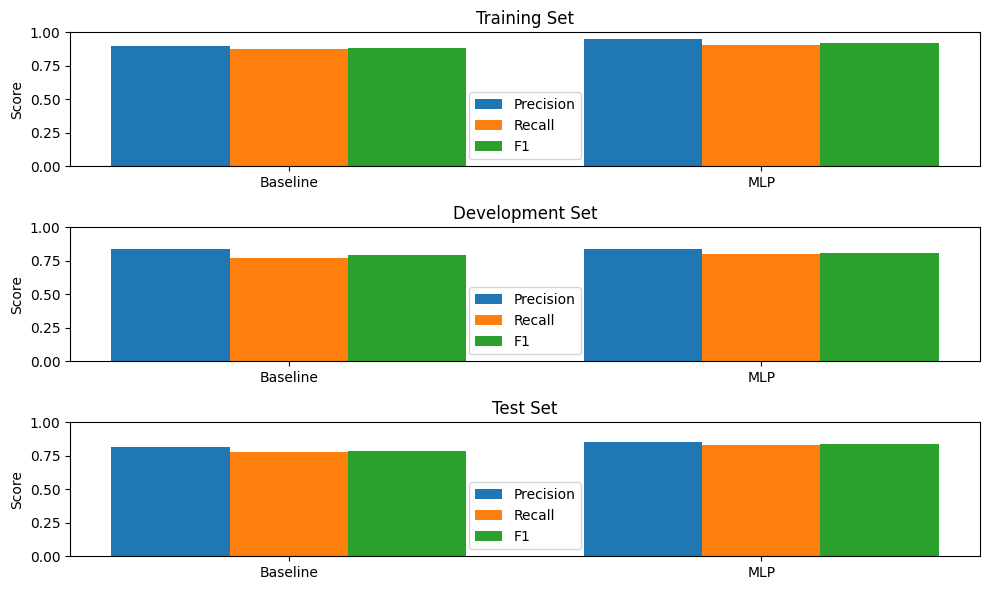

In [ ]:
# Compare baseline and MLP model
plt.figure(figsize=(10, 6))

# Prepare data for comparison
models = ['Baseline', 'MLP']
train_precision = [train_baseline_metrics['macro_precision'], train_mlp_metrics['macro_precision']]
train_recall = [train_baseline_metrics['macro_recall'], train_mlp_metrics['macro_recall']]
train_f1 = [train_baseline_metrics['macro_f1'], train_mlp_metrics['macro_f1']]

dev_precision = [dev_baseline_metrics['macro_precision'], dev_mlp_metrics['macro_precision']]
dev_recall = [dev_baseline_metrics['macro_recall'], dev_mlp_metrics['macro_recall']]
dev_f1 = [dev_baseline_metrics['macro_f1'], dev_mlp_metrics['macro_f1']]

test_precision = [test_baseline_metrics['macro_precision'], test_mlp_metrics['macro_precision']]
test_recall = [test_baseline_metrics['macro_recall'], test_mlp_metrics['macro_recall']]
test_f1 = [test_baseline_metrics['macro_f1'], test_mlp_metrics['macro_f1']]

# Plot comparison
x = np.arange(len(models))
width = 0.25

plt.subplot(3, 1, 1)
plt.bar(x - width, train_precision, width, label='Precision')
plt.bar(x, train_recall, width, label='Recall')
plt.bar(x + width, train_f1, width, label='F1')
plt.ylabel('Score')
plt.title('Training Set')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)

plt.subplot(3, 1, 2)
plt.bar(x - width, dev_precision, width, label='Precision')
plt.bar(x, dev_recall, width, label='Recall')
plt.bar(x + width, dev_f1, width, label='F1')
plt.ylabel('Score')
plt.title('Development Set')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)

plt.subplot(3, 1, 3)
plt.bar(x - width, test_precision, width, label='Precision')
plt.bar(x, test_recall, width, label='Recall')
plt.bar(x + width, test_f1, width, label='F1')
plt.ylabel('Score')
plt.title('Test Set')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Visualize confusion matrix for the most common tags
def plot_confusion_matrix(y_true, y_pred, tag_list, n=10):
    """Plot confusion matrix for the top n most frequent tags."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Get top n tags based on frequency in training data
    tag_counts = Counter()
    for tag in y_train:
        tag_counts[tag] += 1

    top_tag_indices = [tag for tag, _ in tag_counts.most_common(n)]
    top_tag_names = [idx_to_tag[idx] for idx in top_tag_indices]

    # Filter data to only include top tags
    mask_true = np.isin(y_true, top_tag_indices)
    y_true_filtered = y_true[mask_true]
    y_pred_filtered = y_pred[mask_true]

    # Compute confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_tag_indices)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top_tag_names,
                yticklabels=top_tag_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Top Tags')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()



Confusion Matrix for MLP Model (Test Set):


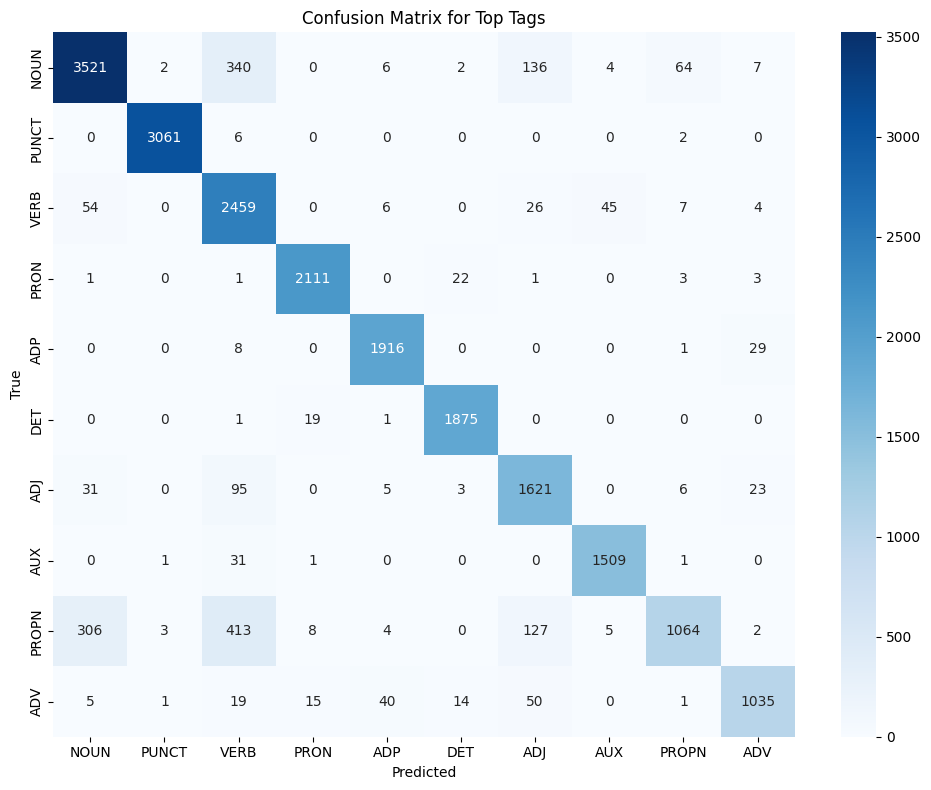


Visualization files saved:
- loss_curves.png: Training and validation loss curves
- per_class_metrics.png: Per-class metrics for the MLP model
- model_comparison.png: Comparison of baseline and MLP models
- confusion_matrix.png: Confusion matrix for the top 10 most frequent tags


In [ ]:
# Plot confusion matrix for the MLP model on the test set
print("\nConfusion Matrix for MLP Model (Test Set):")
plot_confusion_matrix(y_test, test_mlp_preds, idx_to_tag, n=10)

print("\nVisualization files saved:")
print("- loss_curves.png: Training and validation loss curves")
print("- per_class_metrics.png: Per-class metrics for the MLP model")
print("- model_comparison.png: Comparison of baseline and MLP models")
print("- confusion_matrix.png: Confusion matrix for the top 10 most frequent tags")


## 8. Prediction Example

Finally, we'll demonstrate how to use the trained model to predict POS tags for a new sentence.


In [ ]:
# Function to predict POS tags for a single sentence
def predict_sentence(sentence, model, word_to_idx, idx_to_tag, window_size):
    """
    Predict POS tags for a single sentence using the trained model.

    Args:
        sentence: List of words in the sentence
        model: Trained MLP model
        word_to_idx: Word to index mapping
        idx_to_tag: Index to tag mapping
        window_size: Context window size

    Returns:
        List of predicted POS tags for the sentence
    """
    # Convert sentence to lowercase
    sentence = [word.lower() for word in sentence]

    # Prepare data in the same format as training data
    X_word = []
    X_context = []

    for i, word in enumerate(sentence):
        # Get the target word index
        word_idx = word_to_idx.get(word, word_to_idx["<UNK>"])

        # Get context words
        context = []
        for j in range(i - window_size, i + window_size + 1):
            if j < 0 or j >= len(sentence) or j == i:  # Skip target word
                continue
            context_idx = word_to_idx.get(sentence[j], word_to_idx["<UNK>"])
            context.append(context_idx)

        # Pad context if needed
        while len(context) < 2 * window_size:
            context.append(word_to_idx["<PAD>"])

        # Add to dataset
        X_word.append(word_idx)
        X_context.append(context)

    # Convert to numpy arrays
    X_word = np.array(X_word).reshape(-1, 1)
    X_context = np.array(X_context)

    # Make predictions
    probs = model.predict([X_word, X_context])
    preds = np.argmax(probs, axis=1)

    # Convert predictions to tags
    pred_tags = [idx_to_tag[pred] for pred in preds]

    return pred_tags

# Demonstrate using the model to predict POS tags for a single sentence
sample_sentence = ["I", "love", "learning", "about", "natural", "language", "processing", "."]
print("Sample sentence:", sample_sentence)

# Predict POS tags
pred_tags = predict_sentence(sample_sentence, mlp_model, word_to_idx, idx_to_tag, WINDOW_SIZE)

# Display results
print("\nPredicted POS tags:")
for word, tag in zip(sample_sentence, pred_tags):
    print(f"{word}: {tag}")

print("\nPOS Tagging Task Completed Successfully!")


Sample sentence: ['I', 'love', 'learning', 'about', 'natural', 'language', 'processing', '.']
1/1 [==============================] - 0s 17ms/step

Predicted POS tags:
I: PRON
love: VERB
learning: VERB
about: ADP
natural: ADJ
language: NOUN
processing: NOUN
.: PUNCT

POS Tagging Task Completed Successfully!
